Author: Qiu Yang

LSTM encoder, CNN decoder

Data used is toy_dataset in Github, 87% on full test image, 28.7% on half image(shown below) 

Skip the create incomplete dataset section if testing with complete image. 

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import time
import numpy as np
import random
import pickle
import os.path as path
import matplotlib.pyplot as plt
from matplotlib.path import Path
#import generate_data


In [0]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)
torch.cuda.is_available()

cuda


True

# Datasets

**unpack dataset**

In [0]:
data_path  = ''
with open(path.join(data_path,'data_X'),'rb') as f:
    X=pickle.load(f)
    
with open(path.join(data_path,'data_Y'),'rb') as f:
    Y=pickle.load(f)
    
len_train_X=int(len(X)*0.8) #partition data into training and testing

train_data_raw=np.array(X[:len_train_X])
train_label=np.array(Y[:len_train_X])
test_data_raw=np.array(X[len_train_X:])
test_label=np.array(Y[len_train_X:])


print(len(train_data_raw),len(train_label))

print(len(test_data_raw),len(test_label))


35685 35685
8922 8922


In [0]:
#check classes
a = set(train_label)
print(a)

{'penguin', 'snowman', 'calendar', 'teddy-bear', 'blackberry'}


**A random sample**

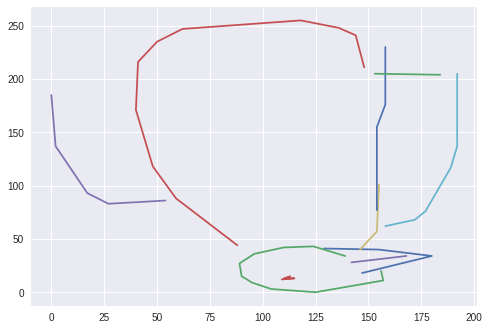

In [0]:
sketch = random.choice(train_data_raw)
for i in range(len(sketch)):
    plt.plot(sketch[i][0][:], sketch[i][1][:])
    
plt.show()

**Sub-sampling(for faster run) and reformat**

In [0]:
#sub sample
train_size=5000
test_size=1000
train_sample = train_data_raw[0:train_size]
train_label_sample = train_label[0:train_size]
test_sample = test_data_raw[0:test_size]
test_label_sample = test_label[0:test_size]
print(len(train_sample))

#reformat into [x,y,l]
no_point = 0; 

def get_min_max_len(sub_sample):
    max_stroke_length = 0
    max_point_length = 0
    min_storkes_length = 500;
    for i in range(len(sub_sample)):
        if len(sub_sample[i])> max_stroke_length: 
            max_stroke_length = len(sub_sample[i])
        if len(sub_sample[i]) < min_storkes_length:
            min_storkes_length = len(sub_sample[i])
        for j in range(len(sub_sample[i])): 
            if len(sub_sample[i][j][0])> max_point_length:
                max_point_length = len(sub_sample[i][j][0])
    return max_stroke_length,max_point_length,min_storkes_length
                
max_stroke_len,max_point_len,min_stroke_len = get_min_max_len(train_sample)    
print (max_stroke_len,max_point_len,min_stroke_len)

def process_data(sub_sample, append):
    stroke_data = []
    point_data = []
    for i in range(len(sub_sample)): #image
        for j in range(len(sub_sample[i])): #strokes
            for k in range(len(sub_sample[i][j][0])): #points
                if append:
                    if k == len(sub_sample[i][j][0])-1:
                        temp2 = [sub_sample[i][j][0][k],sub_sample[i][j][1][k],1]
                    else:
                        temp2 = [sub_sample[i][j][0][k],sub_sample[i][j][1][k],0]
                    point_data.append(temp2)
                else:
                    temp = [sub_sample[i][j][0][k],sub_sample[i][j][1][k]]
                    point_data.append(temp)
        stroke_data.append(point_data)
        point_data = []
            
    return stroke_data   

train_data = process_data(train_sample, 1)
test_data = process_data(test_sample, 1)

print (len(train_data))
print (len(test_data))
print(train_data_raw[0])
print(train_data[0])


5000
61 349 1
5000
1000
[[[30, 24, 23, 25, 33, 68, 131, 151, 160, 163, 164, 150, 128, 79, 49, 37], [90, 81, 41, 34, 26, 12, 0, 17, 32, 48, 99, 114, 118, 117, 103, 85]], [[58, 43, 21, 10, 1, 0, 14, 27, 158, 166, 193, 193, 189, 183, 173, 133, 62, 56, 50], [243, 241, 234, 225, 210, 168, 145, 140, 132, 135, 180, 220, 233, 240, 247, 255, 251, 250, 241]]]
[[30, 90, 0], [24, 81, 0], [23, 41, 0], [25, 34, 0], [33, 26, 0], [68, 12, 0], [131, 0, 0], [151, 17, 0], [160, 32, 0], [163, 48, 0], [164, 99, 0], [150, 114, 0], [128, 118, 0], [79, 117, 0], [49, 103, 0], [37, 85, 1], [58, 243, 0], [43, 241, 0], [21, 234, 0], [10, 225, 0], [1, 210, 0], [0, 168, 0], [14, 145, 0], [27, 140, 0], [158, 132, 0], [166, 135, 0], [193, 180, 0], [193, 220, 0], [189, 233, 0], [183, 240, 0], [173, 247, 0], [133, 255, 0], [62, 251, 0], [56, 250, 0], [50, 241, 1]]


In [0]:
#string to int label for classes
label_set = set(train_label_sample)
label_list = list(label_set)
train_label_tensor = []
for i in range(len(train_label_sample)):
    train_label_tensor.append(label_list.index(train_label_sample[i]))
test_label_set = set(test_label)
test_label_list = list(test_label_set)
test_label_tensor = []
for i in range(len(test_label_sample)):
    test_label_tensor.append(test_label_list.index(test_label_sample[i]))  
print (len(train_label_tensor),train_label_tensor[0],len(test_label_tensor))
print(set(train_label_tensor),set(test_label_tensor))

5000 1 1000
{0, 1, 2, 3, 4} {0, 1, 2, 3, 4}


# **Create incomplete test image (Skip if using complete test data)**

In [0]:
dup_sample = test_sample.copy()
dup_label = test_label_tensor.copy()
print(len(dup_sample))

min_num_strokes = 2
percentage = 0.5   #percentage of the stokes

def sample_random_strokes(dataset,labelset,rand,percent): #rand=1: take stroke randomly, rand=0: take sequentially
    new_set = []
    new_strokes = []
    for i in range(len(dataset)):
        if len(dataset[i]) < min_num_strokes:
            labelset.remove(labelset[i])
            continue
        if rand:
            for j in range(int(len(dataset[i])*percent)):                
                stroke = dataset[i].pop(random.randrange(len(dataset[i])))
                new_strokes.append(stroke)
        else:
            for j in range(int(len(dataset[i])*percent)):                
                stroke = dataset[i][j]
                new_strokes.append(stroke) 
                
        new_set.append(new_strokes)  
        new_strokes = []
        
    return new_set

a= sample_random_strokes(dup_sample,dup_label, 1 ,percentage)
print(len(a),len(dup_label))



1000
989 989


In [0]:
incomp_test_data = process_data(a, 1)
print(len(incomp_test_data),incomp_test_data[0],len(dup_label))

989 [[137, 46, 0], [141, 49, 1], [77, 99, 0], [62, 102, 0], [23, 135, 0], [7, 158, 0], [0, 178, 0], [20, 187, 0], [32, 178, 0], [50, 154, 0], [47, 206, 0], [59, 231, 0], [126, 254, 0], [169, 253, 0], [175, 246, 0], [127, 223, 0], [201, 224, 0], [216, 217, 0], [225, 203, 0], [225, 196, 0], [220, 192, 0], [198, 184, 0], [174, 183, 1], [134, 29, 0], [121, 24, 0], [123, 15, 0], [130, 10, 0], [138, 10, 0], [139, 17, 0], [126, 30, 1], [112, 81, 0], [167, 79, 0], [154, 95, 0], [142, 100, 0], [120, 99, 0], [112, 93, 0], [106, 83, 1]] 989


# Model

In [0]:
#parameters
#train
bs = 50
lr = 12
Epoch = 12
#lstm
input_size = 3
hidden_size = 300
feature_size = 64
#cnn
channels = 1 
kernels = 50
kernel_size = 5
pool_size = 2
output_size = 5
temp_size = 1


** Model_1: one score for each point**

In [0]:
class lstm_cnn (nn.Module):

    def __init__(self):
        super(lstm_cnn, self).__init__()        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.conv = nn.Conv2d(channels, kernels, kernel_size = kernel_size, padding = 1)
        self.pool = nn.MaxPool2d(pool_size, pool_size)
        self.linear2 = nn.Linear(2700, 100)
        self.output = nn.Linear(100, output_size) 
       
    def forward(self, point_seq, h_init, c_init ):
        score_seq = torch.LongTensor([0])
        h_seq , (h_final,c_final)  =   self.lstm( point_seq , (h_init,c_init) )
        h_seq_shaped = h_seq.view(1,1,-1,hidden_size)
        for i in range(h_seq_shaped.shape[2]):
            temp = h_seq_shaped[:,:,i,:]
            temp = temp.reshape(1,1,20,15)
            temp = self.conv(temp)
            temp = F.relu(temp)
            temp = self.pool(temp)
            temp_size = torch.numel(temp)
            temp = temp.reshape(-1,temp_size)
            temp = self.linear2(temp)
            temp = F.relu(temp)
            score = self.output(temp)            
            if i== 0:
                score_seq = score                
            else:
                score_seq = torch.cat((score_seq, score),0)

        return score_seq

**Build the net**

In [0]:
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

net = lstm_cnn()

print(net)

display_num_param(net)

lstm_cnn(
  (lstm): LSTM(3, 300, batch_first=True)
  (conv): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear2): Linear(in_features=2700, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=5, bias=True)
)
There are 637905 (0.64 million) parameters in this neural network


In [0]:
net = net.to(device)

net.linear2.weight.data.uniform_(-0.1, 0.1)
net.output.weight.data.uniform_(-0.1, 0.1)

tensor([[ 0.0100,  0.0597,  0.0020,  0.0450,  0.0966, -0.0704, -0.0304,  0.0188,
         -0.0408,  0.0020,  0.0853, -0.0938, -0.0546, -0.0725, -0.0177,  0.0601,
          0.0694,  0.0202, -0.0189,  0.0798, -0.0658,  0.0693, -0.0447, -0.0021,
         -0.0933, -0.0192, -0.0239, -0.0793,  0.0595, -0.0302, -0.0527, -0.0841,
         -0.0377, -0.0586, -0.0734,  0.0559, -0.0231, -0.0110,  0.0060, -0.0174,
          0.0304, -0.0592, -0.0080,  0.0910, -0.0076, -0.0616, -0.0881, -0.0463,
          0.0204,  0.0507, -0.0249,  0.0115,  0.0592, -0.0587,  0.0267, -0.0435,
         -0.0712, -0.0974,  0.0385, -0.0267, -0.0930,  0.0508, -0.0589,  0.0943,
         -0.0031,  0.0970,  0.0959, -0.0476, -0.0041,  0.0701, -0.0765,  0.0604,
         -0.0398,  0.0652, -0.0013, -0.0108,  0.0170,  0.0224, -0.0604, -0.0905,
         -0.0098, -0.0564,  0.0527, -0.0160,  0.0618, -0.0184, -0.0510, -0.0305,
          0.0171, -0.0185,  0.0387,  0.0217,  0.0552, -0.0716, -0.0035, -0.0096,
         -0.0229, -0.0513, -

**Loss function**

In [0]:
criterion = nn.CrossEntropyLoss()


# Training and evaluation

In [0]:
def eval_on_test_set():

    running_loss=0
    num_batches=0    
    
    correct = 0
    
    correct_0 = 0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    correct_4 = 0
    
    h = torch.zeros(1, 1, hidden_size)
    c = torch.zeros(1, 1, hidden_size)
   
    h=h.to(device)
    c=c.to(device)
       
    for count in range( len(incomp_test_data)) : #change all incomp_test_data to test_data if testing complete image
               
        minibatch_data =  incomp_test_data[ count  ]
        minibatch_data = torch.Tensor(minibatch_data).view(1,-1,3)

        minibatch_label = []
        for i in range(minibatch_data.shape[1]):
            minibatch_label.append(dup_label[ count ])
        minibatch_label = torch.LongTensor([minibatch_label]).view(-1)
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
                                  
        scores = net( minibatch_data, h , c)

        loss = criterion(  scores ,  minibatch_label )    
        
        h=h.detach()
        c=c.detach()
            
        running_loss += loss.item()
        num_batches += 1        
        
        scores = F.relu(scores)
        total_score = torch.sum(scores,0)  
        _, predicted = torch.max(total_score,0)

        if predicted == minibatch_label[0]:
            correct+=1
            if predicted == 0:
                correct_0+=1
            elif predicted == 1:
                correct_1+=1
            elif predicted == 2:
                correct_2+=1                
            elif predicted == 3:
                correct_3+=1   
            elif predicted == 4:
                correct_4+=1                
    
    total_loss = running_loss/num_batches 
    print('test: exp(loss) = ', math.exp(total_loss)  )
    print ('correct', correct, 'c_0', correct_0,'c_1',correct_1,'c_2', correct_2,'c_3',correct_3,'c_4',correct_4)
    print ('Test accuracy:{}%'.format(100 * correct / len(test_data)))

**Training by batch of image (not exactly by batch, append in 1 row to avoid uneven tensor shape. )**

In [0]:
start=time.time()

for epoch in range(Epoch):
    
    optimizer=torch.optim.Adam( net.parameters())
        
    running_loss=0
    num_batches=0    
       
    h = torch.zeros( 1, 1, hidden_size)
    c = torch.zeros( 1, 1, hidden_size)
   
    h=h.to(device)
    c=c.to(device)
    
    for count in range(0,len(train_data),bs):
        
        optimizer.zero_grad()
        
        minibatch_data_bs =  train_data[ count:count+bs]
        
        minibatch_data = []
        for i in range(len(minibatch_data_bs)):
            for j in range (len(minibatch_data_bs[i])):
                minibatch_data.append(minibatch_data_bs[i][j])          
        minibatch_data = torch.Tensor(minibatch_data).view(1,-1,3)

        minibatch_label = []
        for k in range(len(minibatch_data_bs)):
            for l in range(len(minibatch_data_bs[k])):
                minibatch_label.append(train_label_tensor[ count+k ])       
        minibatch_label = torch.LongTensor([minibatch_label]).view(-1)

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        h=h.detach()
        c=c.detach()
        h=h.requires_grad_()
        c=c.requires_grad_()
                            
        scores = net( minibatch_data, h , c )

        loss = criterion(  scores ,  minibatch_label )
        
        loss.backward()
       
        optimizer.step()
        
        running_loss += loss.item()
        num_batches += 1
        
    total_loss = running_loss/num_batches
    elapsed = time.time()-start
    
    print('')
    print('epoch=',epoch, '\t time=', elapsed, '\t exp(loss)=',  math.exp(total_loss))
    for param_group in optimizer.param_groups:
        print('lr= ',param_group['lr'])
        
    eval_on_test_set()



epoch= 0 	 time= 801.7962701320648 	 exp(loss)= 2.703946934991306
lr=  0.001
test: exp(loss) =  7.4713609213588565
correct 265 c_0 46 c_1 61 c_2 100 c_3 12 c_4 46
Test accuracy:26.5%

epoch= 1 	 time= 1617.4688956737518 	 exp(loss)= 2.5322300442396863
lr=  0.001
test: exp(loss) =  7.868999622455982
correct 263 c_0 46 c_1 62 c_2 93 c_3 16 c_4 46
Test accuracy:26.3%

epoch= 2 	 time= 2428.161203622818 	 exp(loss)= 2.3722745986182665
lr=  0.001
test: exp(loss) =  8.151340626972232
correct 268 c_0 53 c_1 65 c_2 90 c_3 16 c_4 44
Test accuracy:26.8%

epoch= 3 	 time= 3237.3708624839783 	 exp(loss)= 2.262513968211022
lr=  0.001
test: exp(loss) =  8.214737406514903
correct 268 c_0 48 c_1 73 c_2 90 c_3 14 c_4 43
Test accuracy:26.8%

epoch= 4 	 time= 4045.487145423889 	 exp(loss)= 2.183380749826333
lr=  0.001
test: exp(loss) =  8.35510646154574
correct 276 c_0 61 c_1 72 c_2 91 c_3 14 c_4 38
Test accuracy:27.6%

epoch= 5 	 time= 4853.626063108444 	 exp(loss)= 2.133085899399462
lr=  0.001
test: e